# Cars Prices Prediction

In [2]:

import numpy as np
import pandas as pd
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from autogluon.tabular import TabularDataset, TabularPredictor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report


from pycaret import *

# 2. Data Preparation

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter


file_path = "Cars Datasets 2025.csv"


df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "abdulmalik1518/cars-datasets-2025",
  file_path,
  pandas_kwargs={'encoding': 'latin1'}
  
)

print("First 5 records:", df.head())

First 5 records:   Company Names     Cars Names      Engines CC/Battery Capacity HorsePower  \
0       FERRARI  SF90 STRADALE           V8             3990 cc     963 hp   
1   ROLLS ROYCE        PHANTOM          V12             6749 cc     563 hp   
2          Ford            KA+  1.2L Petrol            1,200 cc   70-85 hp   
3      MERCEDES        GT 63 S           V8            3,982 cc     630 hp   
4          AUDI     AUDI R8 Gt          V10            5,204 cc     602 hp   

  Total Speed Performance(0 - 100 )KM/H      Cars Prices       Fuel Types  \
0    340 km/h                   2.5 sec      $1,100,000   plug in hyrbrid   
1    250 km/h                   5.3 sec        $460,000            Petrol   
2    165 km/h                  10.5 sec  $12,000-$15,000           Petrol   
3    250 km/h                   3.2 sec        $161,000            Petrol   
4    320 km/h                   3.6 sec        $253,290            Petrol   

  Seats        Torque  
0     2        800 Nm  
1  

In [6]:
import re


def extract_number(value):
    if pd.isna(value) or str(value).lower() == 'none':
        return np.nan
    clean_val = str(value).replace(',', '').replace('$', '')
    clean_val = re.sub(r'[a-zA-Z/ ]', '', clean_val)
    
    if '-' in clean_val:
        
        parts = [p for p in clean_val.split('-') if p.strip()]
        if len(parts) == 2:
            try: return (float(parts[0]) + float(parts[1])) / 2
            except: return np.nan
        elif len(parts) == 1:
            try: return float(parts[0])
            except: return np.nan
    
    try: return float(clean_val)
    except: return np.nan


df_clean = df.copy()
text_num_features = ['HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']
target_col = 'Cars Prices'


for col in text_num_features + [target_col]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].apply(extract_number)


df_clean = df_clean.dropna(subset=[target_col])
for col in text_num_features:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())


upper_limit = df_clean[target_col].quantile(0.99)
df_clean = df_clean[df_clean[target_col] <= upper_limit].copy()


df_clean[target_col] = np.log1p(df_clean[target_col])


train_data, test_data = train_test_split(df_clean, test_size=0.2, random_state=42)

In [8]:
df_viz = df.copy()


print("Current Columns:", df_viz.columns.tolist())


df_viz.head()

Current Columns: ['Company Names', 'Cars Names', 'Engines', 'CC/Battery Capacity', 'HorsePower', 'Total Speed', 'Performance(0 - 100 )KM/H', 'Cars Prices', 'Fuel Types', 'Seats', 'Torque']


,Company Names,Cars Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
0,FERRARI,SF90 STRADALE,V8,3990 cc,963 hp,340 km/h,2.5 sec,"$1,100,000",plug in hyrbrid,2,800 Nm
1,ROLLS ROYCE,PHANTOM,V12,6749 cc,563 hp,250 km/h,5.3 sec,"$460,000",Petrol,5,900 Nm
2,Ford,KA+,1.2L Petrol,"1,200 cc",70-85 hp,165 km/h,10.5 sec,"$12,000-$15,000",Petrol,5,100 - 140 Nm
3,MERCEDES,GT 63 S,V8,"3,982 cc",630 hp,250 km/h,3.2 sec,"$161,000",Petrol,4,900 Nm
4,AUDI,AUDI R8 Gt,V10,"5,204 cc",602 hp,320 km/h,3.6 sec,"$253,290",Petrol,2,560 Nm


In [9]:
import plotly.express as px


for col in ['Company Names', 'Fuel Types']:
    
    top_10 = df_clean[col].value_counts().nlargest(10).index
    df_plot = df_clean[df_clean[col].isin(top_10)]
    
   
    df_agg = df_plot.groupby(col)['Cars Prices'].mean().reset_index()
    
    fig = px.bar(
        df_agg, 
        x=col, 
        y='Cars Prices',
        color='Cars Prices',
        title=f"Average Price by {col}",
        labels={'Cars Prices': 'Average Price ($)'},
        template='plotly_white'
    )
    fig.update_layout(yaxis_tickformat='$,.0f')
    fig.show()


for col in ['HorsePower', 'Total Speed']:
    fig = px.scatter(
        df_clean, 
        x=col, 
        y='Cars Prices',
        trendline="ols", 
        title=f"Correlation: {col} (Scaled) vs Price",
        labels={col: f"{col} (Standardized Units)", 'Cars Prices': 'Price ($)'},
        template='plotly_white'
    )
    fig.update_layout(yaxis_tickformat='$,.0f')
    fig.show()

In [10]:
df_ready = df_clean.copy()

target_col = 'Cars Prices'


cat_features = ['Company Names', 'Cars Names', 'Fuel Types']
num_features = ['HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']


features_name = [f for f in (cat_features + num_features) if f in df_ready.columns and f != target_col]


df_model = df_ready[features_name + [target_col]].copy()

print(f"Preprocessing Success!")
print(f"Features for Regression: {features_name}")
print(f"Target Variable: {target_col}")
print(f"Final Data Shape: {df_model.shape}")

Preprocessing Success!
Features for Regression: ['Company Names', 'Cars Names', 'Fuel Types', 'HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']
Target Variable: Cars Prices
Final Data Shape: (1200, 8)


AutoGluon

In [11]:
features = ['Company Names', 'Cars Names', 'Fuel Types', 'HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']


target = 'Cars Prices'


existing_features = [f for f in features if f in df_ready.columns]
data_for_ag = df_ready[existing_features + [target]].copy()


train_data, test_data = train_test_split(data_for_ag, test_size=0.2, random_state=42)

print(f"--- Model Setup Complete for Price Prediction ---")
print(f"Target: Predicting exact price in dollars ({target})")
print(f"Features used: {existing_features}")
print(f"Training size: {len(train_data)} rows")
print(f"Testing size: {len(test_data)} rows")

--- Model Setup Complete for Price Prediction ---
Target: Predicting exact price in dollars (Cars Prices)
Features used: ['Company Names', 'Cars Names', 'Fuel Types', 'HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']
Training size: 960 rows
Testing size: 240 rows


In [12]:
from autogluon.tabular import TabularPredictor


predictor = TabularPredictor(
    label='Cars Prices', 
    problem_type='regression', 
    eval_metric='mean_absolute_error' 
).fit(
    train_data,
    presets='medium_quality', 
    time_limit=300
    
)


performance = predictor.evaluate(test_data)


mae_score = abs(performance['mean_absolute_error'])
print(f"--- Model Performance ---")
print(f"Mean Absolute Error (MAE): ${mae_score:,.2f}")
print(f"MAE tells us: On average, our price guess is off by ${mae_score:,.2f}")

No path specified. Models will be saved in: "AutogluonModels\ag-20260103_165334"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          8
Pytorch Version:    2.7.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       1.12 GB / 15.77 GB (7.1%)
Disk Space Avail:   33.49 GB / 952.53 GB (3.5%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "c:\Users\Komail AL-Basri\bootcoamp\week3-ml-baseline-system\notebooks\AutogluonModels\ag-20260103_165334"
Train Data Rows:    960
Train Data Columns: 7
Label Column:       Cars Prices
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...


[1000]	valid_set's l1: 0.201951
[2000]	valid_set's l1: 0.191725
[3000]	valid_set's l1: 0.187428
[4000]	valid_set's l1: 0.184987
[5000]	valid_set's l1: 0.183824
[6000]	valid_set's l1: 0.183867
[7000]	valid_set's l1: 0.183102
[8000]	valid_set's l1: 0.183474
[9000]	valid_set's l1: 0.183311


	-0.183	 = Validation score   (-mean_absolute_error)
	3.86s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 295.72s of the 295.69s of remaining time.
	Fitting with cpus=4, gpus=0, mem=0.0/1.1 GB
	-0.1838	 = Validation score   (-mean_absolute_error)
	0.41s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 295.26s of the 295.24s of remaining time.
	Fitting with cpus=8, gpus=0
	-0.1953	 = Validation score   (-mean_absolute_error)
	0.54s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 294.65s of the 294.63s of remaining time.
	Fitting with cpus=4, gpus=0
	-0.1891	 = Validation score   (-mean_absolute_error)
	137.47s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 157.15s of the 157.13s of remaining time.
	Fitting with cpus=8, gpus=0
	-0.1944	 = Validation score

--- Model Performance ---
Mean Absolute Error (MAE): $0.16
MAE tells us: On average, our price guess is off by $0.16


In [13]:
lb = predictor.leaderboard(test_data, extra_metrics=['r2'])

display(lb[['model', 'score_test', 'r2', 'fit_time']])

,model,score_test,r2,fit_time
0,WeightedEnsemble_L2,-0.155939,0.921819,29.291293
1,XGBoost,-0.161289,0.924824,0.792957
2,NeuralNetTorch,-0.166462,0.904548,24.037036
3,ExtraTreesMSE,-0.167723,0.921643,0.600110
4,LightGBMXT,-0.169168,0.909033,3.855191
5,RandomForestMSE,-0.169673,0.916852,0.540124
6,LightGBM,-0.174138,0.909803,0.413523
7,CatBoost,-0.174461,0.914602,137.468912
8,LightGBMLarge,-0.180256,0.912357,1.653804
9,NeuralNetFastAI,-0.281071,0.818195,3.993714


In [14]:
lb = predictor.leaderboard(test_data, extra_metrics=['r2'])


print(lb[['model', 'score_test', 'r2']])

                 model  score_test        r2
0  WeightedEnsemble_L2   -0.155939  0.921819
1              XGBoost   -0.161289  0.924824
2       NeuralNetTorch   -0.166462  0.904548
3        ExtraTreesMSE   -0.167723  0.921643
4           LightGBMXT   -0.169168  0.909033
5      RandomForestMSE   -0.169673  0.916852
6             LightGBM   -0.174138  0.909803
7             CatBoost   -0.174461  0.914602
8        LightGBMLarge   -0.180256  0.912357
9      NeuralNetFastAI   -0.281071  0.818195


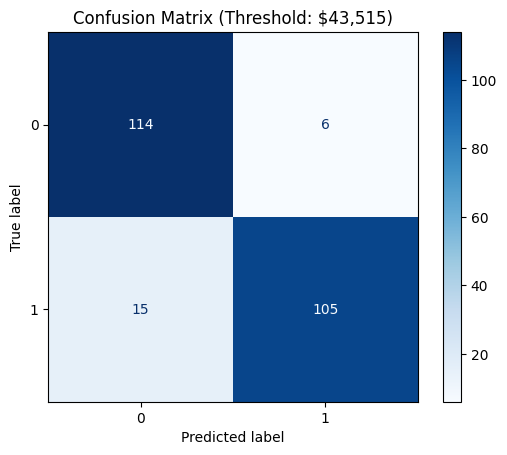

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


y_true_dollars = np.expm1(test_data[target_col])
y_pred_dollars = np.expm1(predictor.predict(test_data))


threshold = y_true_dollars.median()


y_true_class = (y_true_dollars > threshold).astype(int)
y_pred_class = (y_pred_dollars > threshold).astype(int)

cm = confusion_matrix(y_true_class, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix (Threshold: ${threshold:,.0f})")
plt.show()


manually

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_features_clean = ['HorsePower', 'Total Speed', 'Torque', 'CC/Battery Capacity']


num_features_clean = [c for c in num_features_clean if c in df_clean.columns]


cat_features_clean = ['Company Names', 'Cars Names', 'Fuel Types']


target_col = 'Cars Prices'
preprocessor = ColumnTransformer(
    transformers=[
       
        ('num', StandardScaler(), num_features_clean),
        
        
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features_clean)
    ]
)

print(" Done Preprocessor ")

 Done Preprocessor 


In [20]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score


features_name = num_features_clean + cat_features_clean
X = df_clean[features_name]
y = df_clean['Cars Prices'] 


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 1. (WeightedEnsemble_L2)

ensemble_model = VotingRegressor(
    estimators=[
        ('cat', CatBoostRegressor(iterations=500, verbose=0, random_state=42)),
        ('xgb', XGBRegressor(n_estimators=100, random_state=42))
    ],
    weights=[3, 2] 
)
ensemble_pipe = Pipeline([('prep', preprocessor), ('model', ensemble_model)])


ensemble_r2 = cross_val_score(ensemble_pipe, X_train, y_train, cv=5, scoring='r2').mean()

# 2. Random Forest
rf_model = Pipeline([
    ('prep', preprocessor), 
    ('model', RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42))
])
rf_r2 = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2').mean()


print(f"Manual Model Performance (R2 Score):")
print(f"Weighted Ensemble: {ensemble_r2:.4f}")
print(f"Random Forest:     {rf_r2:.4f}")

Manual Model Performance (R2 Score):
Weighted Ensemble: 0.8993
Random Forest:     0.8897
